In [1]:
import torch

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ignite.metrics as ig

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

import os
from PIL import Image

import time

In [2]:
batch_size = 6

In [3]:
class PairedImageDataset(Dataset):
    def __init__(self, distorted_folder_path, original_folder_path, transform=None):
        self.distorted_folder_path = distorted_folder_path
        self.original_folder_path = original_folder_path
        self.orig_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((320, 320))
        ])
        self.rec_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((320, 320))
        ])
        self.distorted_image_files = sorted([f for f in os.listdir(distorted_folder_path) if f.endswith(('png', 'jpg', 'jpeg'))])
        self.original_image_files = sorted([f for f in os.listdir(original_folder_path) if f.endswith(('png', 'jpg', 'jpeg'))])
        assert len(self.distorted_image_files) == len(self.original_image_files), "Количество изображений в папках должно совпадать"

    def __len__(self):
        return len(self.distorted_image_files)

    def __getitem__(self, idx):
        distorted_img_path = os.path.join(self.distorted_folder_path, self.distorted_image_files[idx])
        original_img_path = os.path.join(self.original_folder_path, self.original_image_files[idx])
        
        distorted_image = Image.open(distorted_img_path).convert('RGB')
        original_image = Image.open(original_img_path).convert('RGB')
        
        distorted_image = self.orig_transform(distorted_image)
        original_image = self.rec_transform(original_image)
        
        return distorted_image, original_image

dataset = PairedImageDataset('Orig', 'Record')
dataloader = DataLoader(dataset, batch_size = batch_size, pin_memory = True, shuffle = True)
subset = torch.utils.data.Subset(dataset, list(range(0, 16000, 16)))
val_loader = DataLoader(subset, batch_size = batch_size, pin_memory = True, shuffle = False)


def show_images_real(orig, record, real, size):
  f, axes = plt.subplots(3, size, figsize = (30, 16))
  for i, ax in enumerate(axes.ravel()):
    if i < size:
        image = orig[i].detach().numpy()
        image = image.transpose((1, 2, 0))
        ax.imshow(image)
    elif i < 2 * size:
        image = record[i - size].detach().numpy()
        image = image.transpose((1, 2, 0))
        ax.imshow(image)
    else:
        image = real[i - 2 * size].detach().numpy()
        image = image.transpose((1, 2, 0))
        ax.imshow(image)
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Модель

In [4]:

'''
class DenseBlock(nn.Module):
    def __init__(self, channels, num_conv):
        super().__init__()
        self.c1 = nn.Conv2d(channels, channels, 3, padding = 1)
        self.c2 = nn.Conv2d(channels, channels, 3, padding = 1)
        self.c3 = nn.Conv2d(channels, channels, 3, padding = 1)
        self.c4 = nn.Conv2d(channels, channels, 3, padding = 1)
        self.c5 = nn.Conv2d(channels, channels, 3, padding = 1)
        
    def forward(self, x):
        x0 = x
        x = leaky_relu(self.c1(x))
        x1 = x
        x = x + x0
        x = leaky_relu(self.c2(x))
        x2 = x
        x = x + x0 + x1
        x = leaky_relu(self.c3(x))
        x3 = x
        x = x + x0 + x1 + x2
        x = leaky_relu(self.c4(x))
        x = x + x0 + x1 + x2 + x3
        x = c5(x)
        return x
'''

def rgb_to_YCC(x):
    r = x[:, 0, :, :].unsqueeze(1)
    g = x[:, 1, :, :].unsqueeze(1)
    b = x[:, 2, :, :].unsqueeze(1)
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = (b - y) * 0.564 + 0.5
    cr = (r - y) * 0.713 + 0.5
    return y, cb, cr

def YCC_to_rgb(x):
    y = x[:, 0, :, :].unsqueeze(1)
    cb = x[:, 1, :, :].unsqueeze(1)
    cr = x[:, 2, :, :].unsqueeze(1)
    r = y + 1.402 * (cr - 0.5)
    g = y - 0.344136 * (cb - 0.5) - 0.714136 * (cr - 0.5)
    b = y + 1.772 * (cb - 0.5)
    img = torch.cat((r, g, b), dim = 1)
    return img

class DenseBlock(nn.Module):
    def __init__(self, channels, num_conv):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1) for _ in range(num_conv - 1)])
        self.c = nn.Conv2d(channels, channels, 3, padding = 1)
        
    def forward(self, x):
        x_prev = []
        #print(f'x dense shape:{x.shape}')
        for conv in self.convs:
            x_prev.append(x)
            #print(f'x dense shape:{x.shape}')
            x = F.leaky_relu(conv(x))
            x = x + sum(x_prev)
        x = self.c(x)
        return x


class RRDB(nn.Module):
    def __init__(self, beta = 0.2, num_blocks = 5):
        super().__init__()
        self.beta = beta
        self.blocks = nn.ModuleList([DenseBlock(64, 5) for _ in range(num_blocks)])
        
    def forward(self, x):
        x0 = x
        for block in self.blocks:
            x1 = x
            x = block(x)
            x = x1 + self.beta * x
        x = self.beta * x + x0
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, channels):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels = in_channels, out_channels = channels, kernel_size = 1)
        self.c2 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
        self.c3 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
    def forward(self, x):
        x = self.c1(x)
        x = F.leaky_relu(self.c2(x))
        x = F.leaky_relu(self.c3(x))
        return x
        
class Decoder(nn.Module):
    def __init__(self, channels, out_channels):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
        self.c2 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
        self.c3 = nn.Conv2d(in_channels = channels, out_channels = out_channels, kernel_size = 1, padding = 0)
    def forward(self, x):
        x = F.leaky_relu(self.c1(x))
        x = F.leaky_relu(self.c2(x))
        x = F.tanh(self.c3(x))
        return x

class Luma(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder(in_channels = 1, channels = 64)
        self.rdrb = RRDB(num_blocks = 5)
        self.dec = Decoder(channels = 64, out_channels = 1)
    def forward(self, x):
        x = self.enc(x)
        x = self.rdrb(x)
        x = self.dec(x)
        return x

class Chroma(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder(in_channels = 3, channels = 64)
        self.rdrb = RRDB(num_blocks = 3)
        self.dec = Decoder(channels = 64, out_channels = 2)
    def forward(self, x):
        x = self.enc(x)
        x = self.rdrb(x)
        x = self.dec(x)
        return x
        
class Model(nn.Module): #DRA
    def __init__(self):
        super().__init__()
        self.luma = Luma()
        self.chroma = Chroma()
    def forward(self, x):
        y, cb, cr = rgb_to_YCC(x)
        #print(f'y shape:{y.shape}')
        y = self.luma(y)
        #print(f'yl shape:{y.shape}')
        y1 = y
        ycbcr = torch.cat((y, cb, cr), dim = 1)
        cbcr = self.chroma(ycbcr)
        x = torch.cat((y, cbcr), dim = 1)
        x = YCC_to_rgb(x)
        return x

Выбираем лосс функцию

In [5]:
# L2
loss_fn = torch.nn.MSELoss()

In [5]:
# L1
loss_fn = torch.nn.L1Loss()

Настройки обучения

In [6]:
model = Model().to(device)

In [7]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [8]:
optimiser = torch.optim.Adam(model.parameters(), lr = 2e-5)

Фукнция для измерения loss на всём монжестве

In [9]:
from tqdm import tqdm
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        loss = 0
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            x, y = batch
            y_pred = model(x.to(device))
            loss = loss + loss_fn(y_pred, y.to(device))
        print(f'loss = {loss / len(dataloader)}')
    model.train()

In [10]:
save_interval = 60

In [11]:
iterations = 0

In [12]:
from torch.utils.tensorboard import SummaryWriter    
writer = SummaryWriter('runs')

Обучение

epoch: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Прошло времени:  60.67988991737366 c


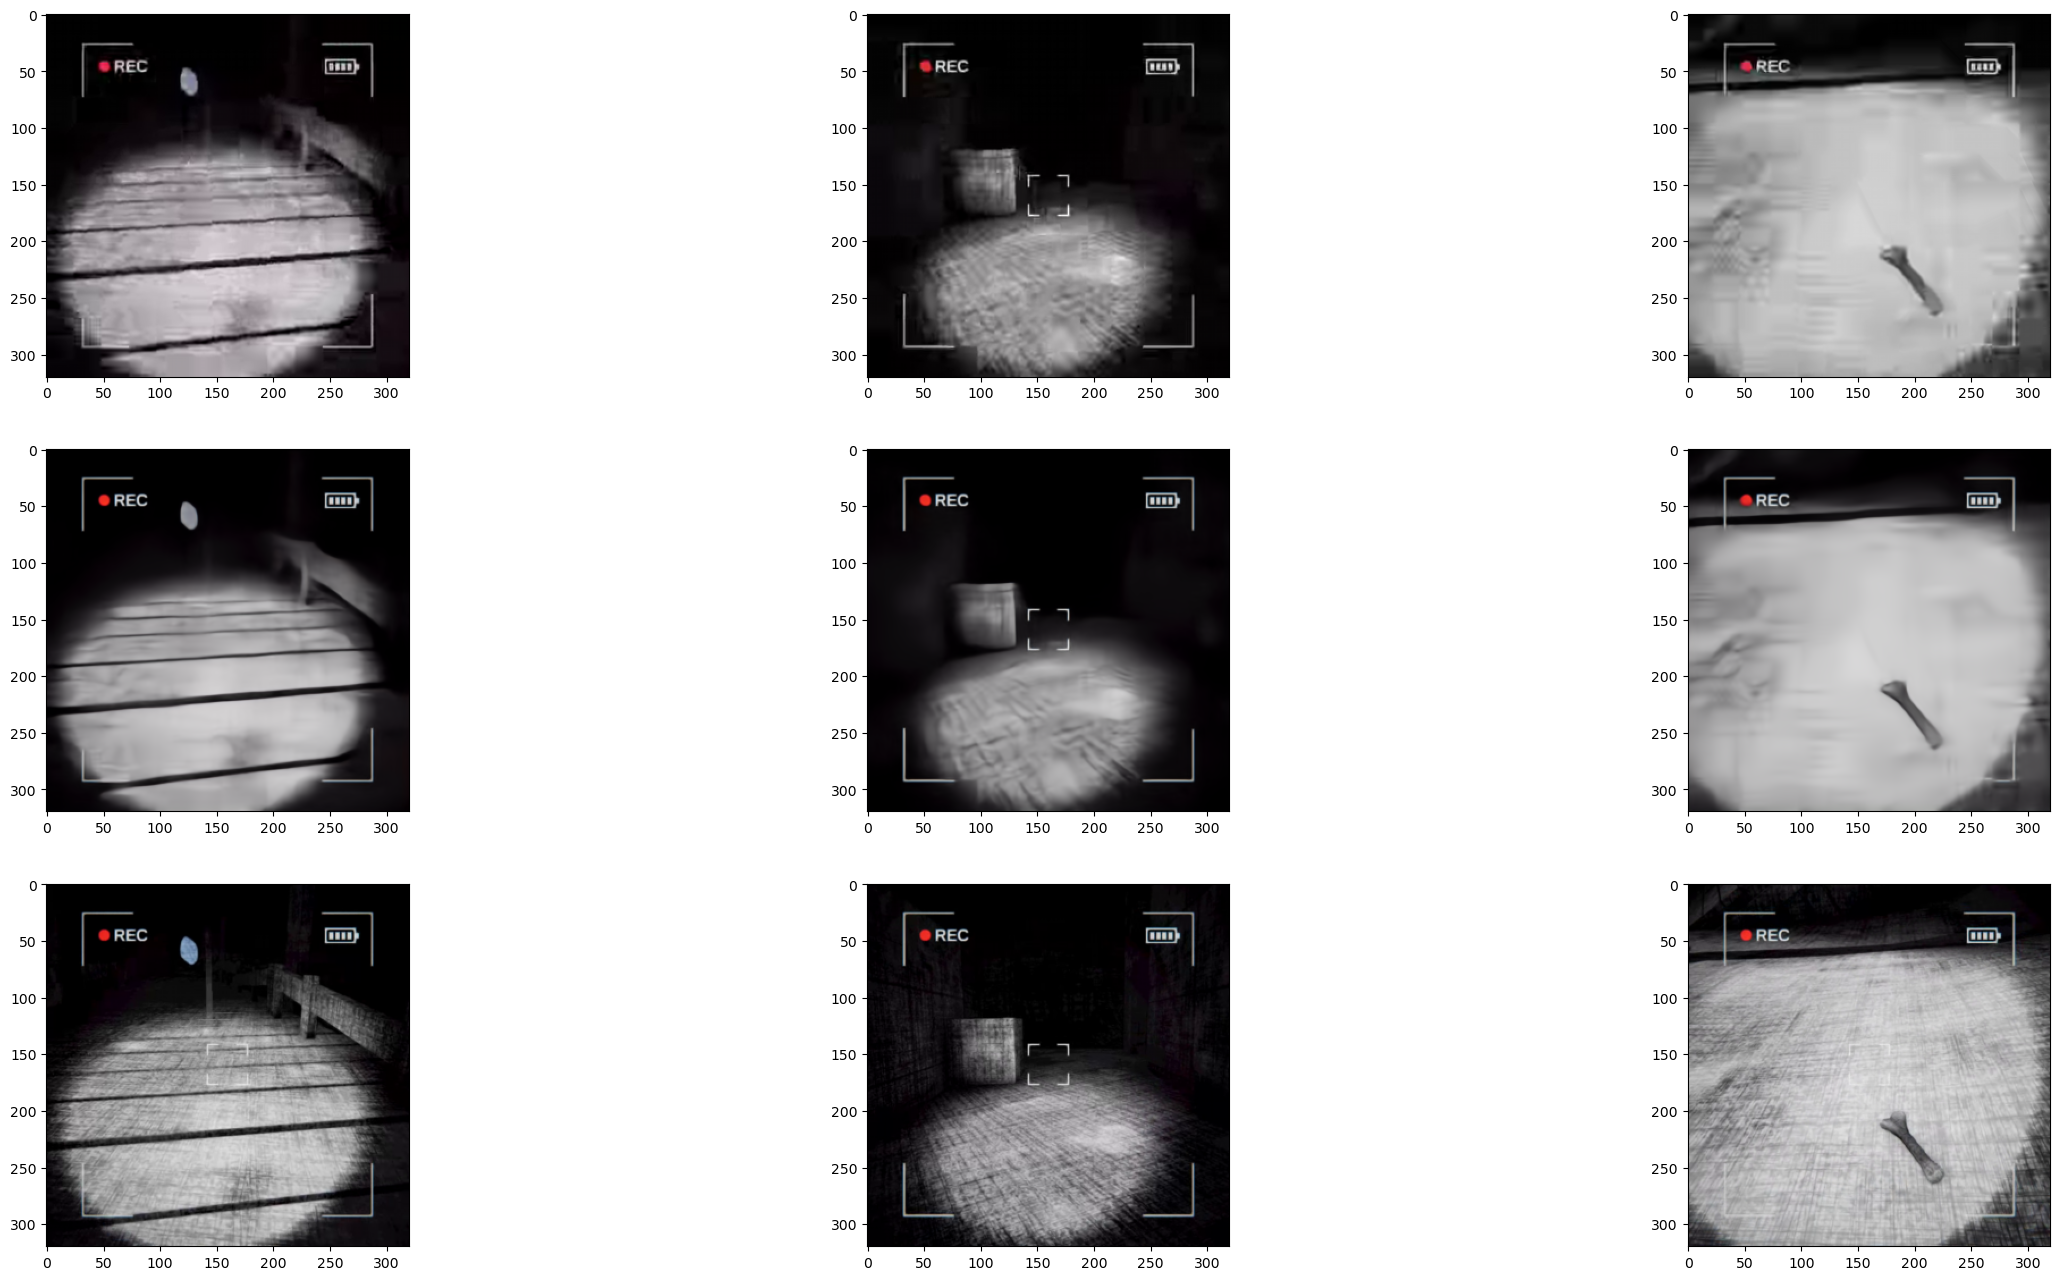

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Прошло времени:  120.9526801109314 c


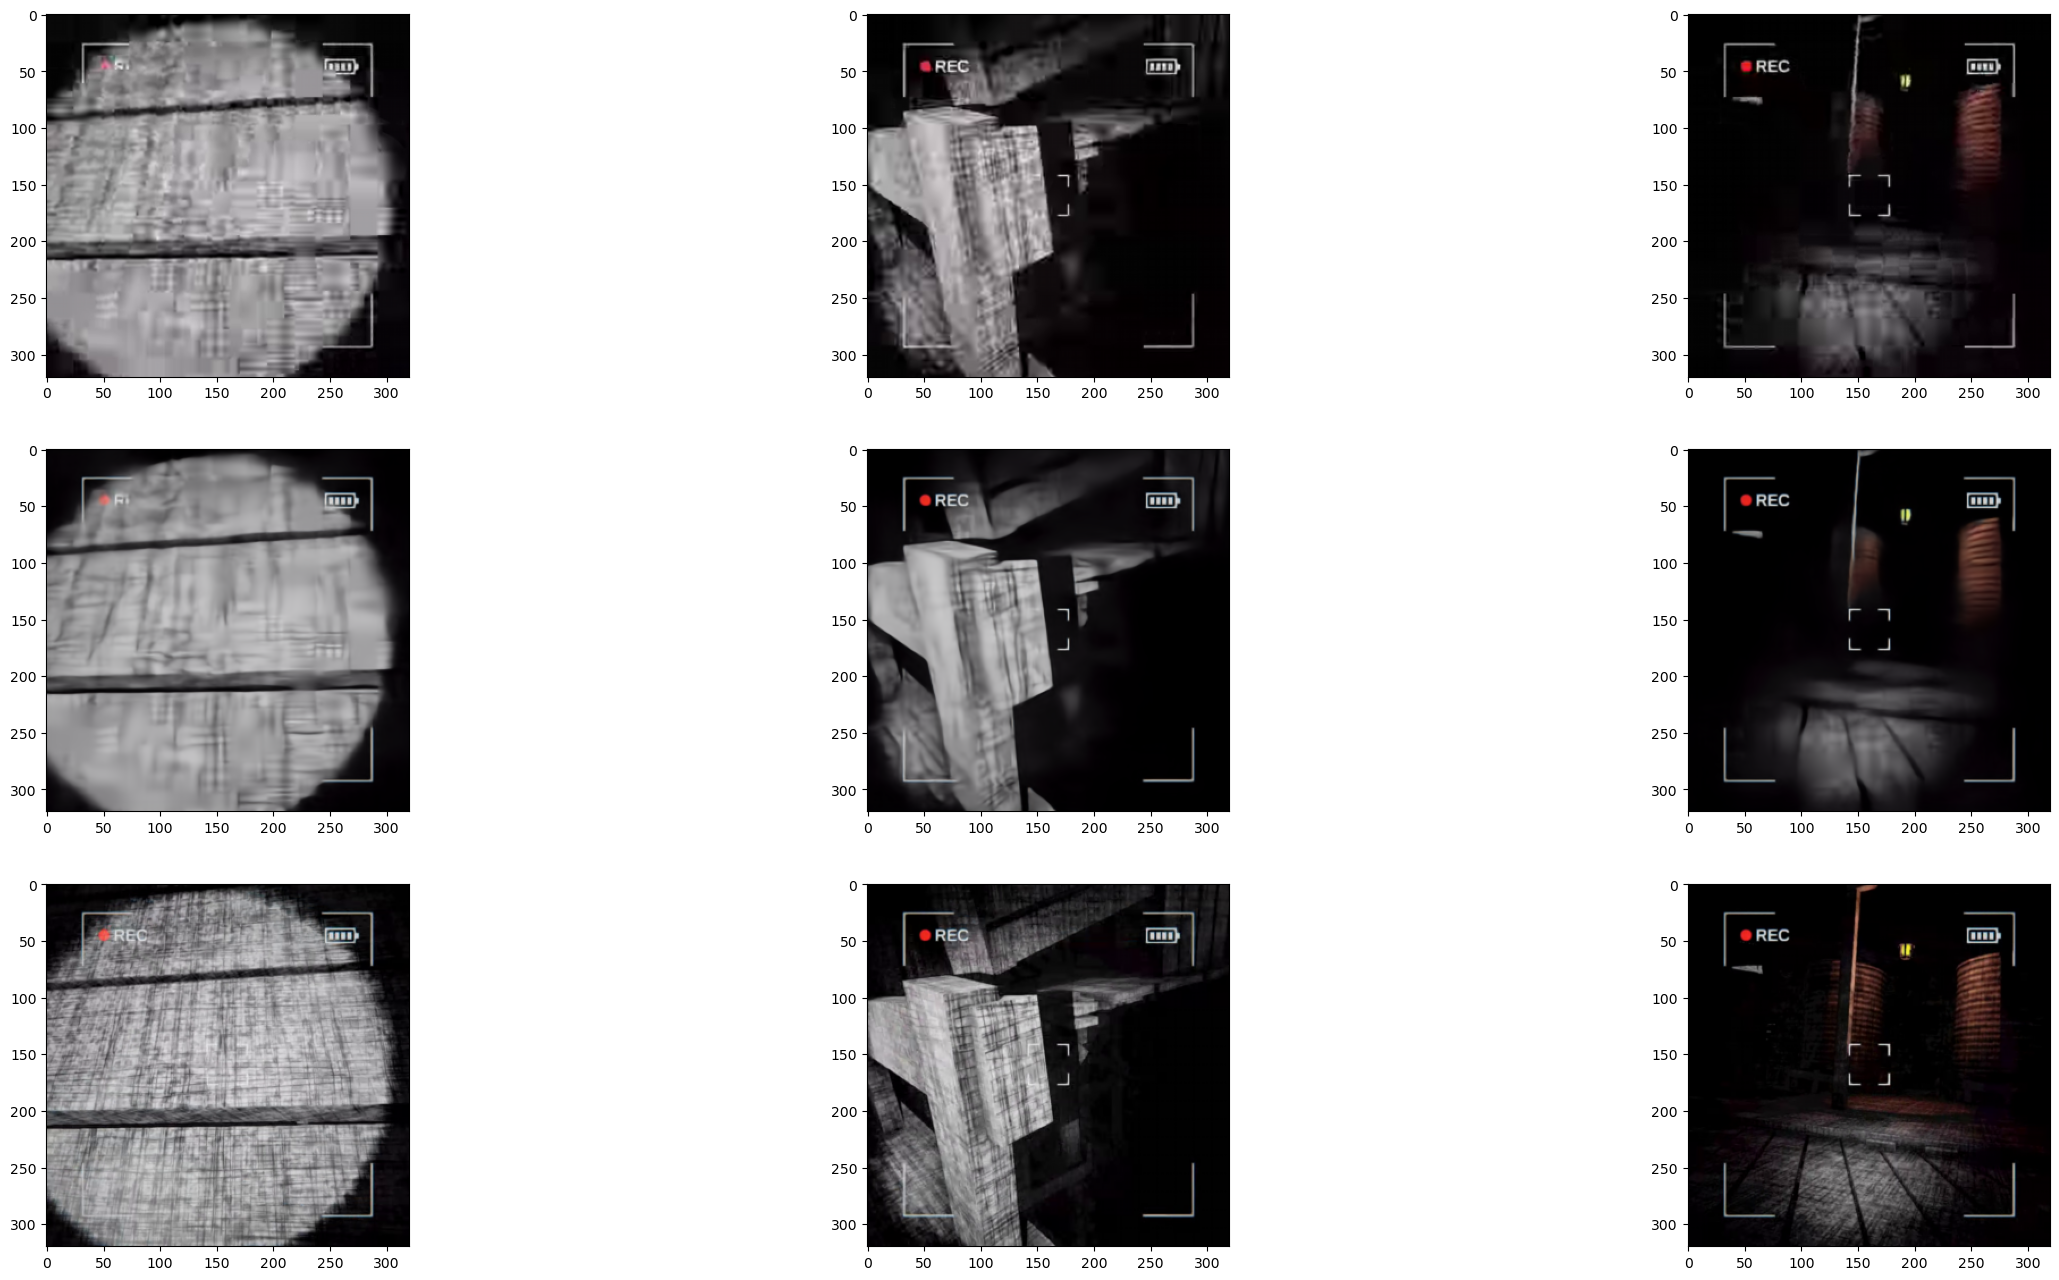

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Прошло времени:  181.08221888542175 c


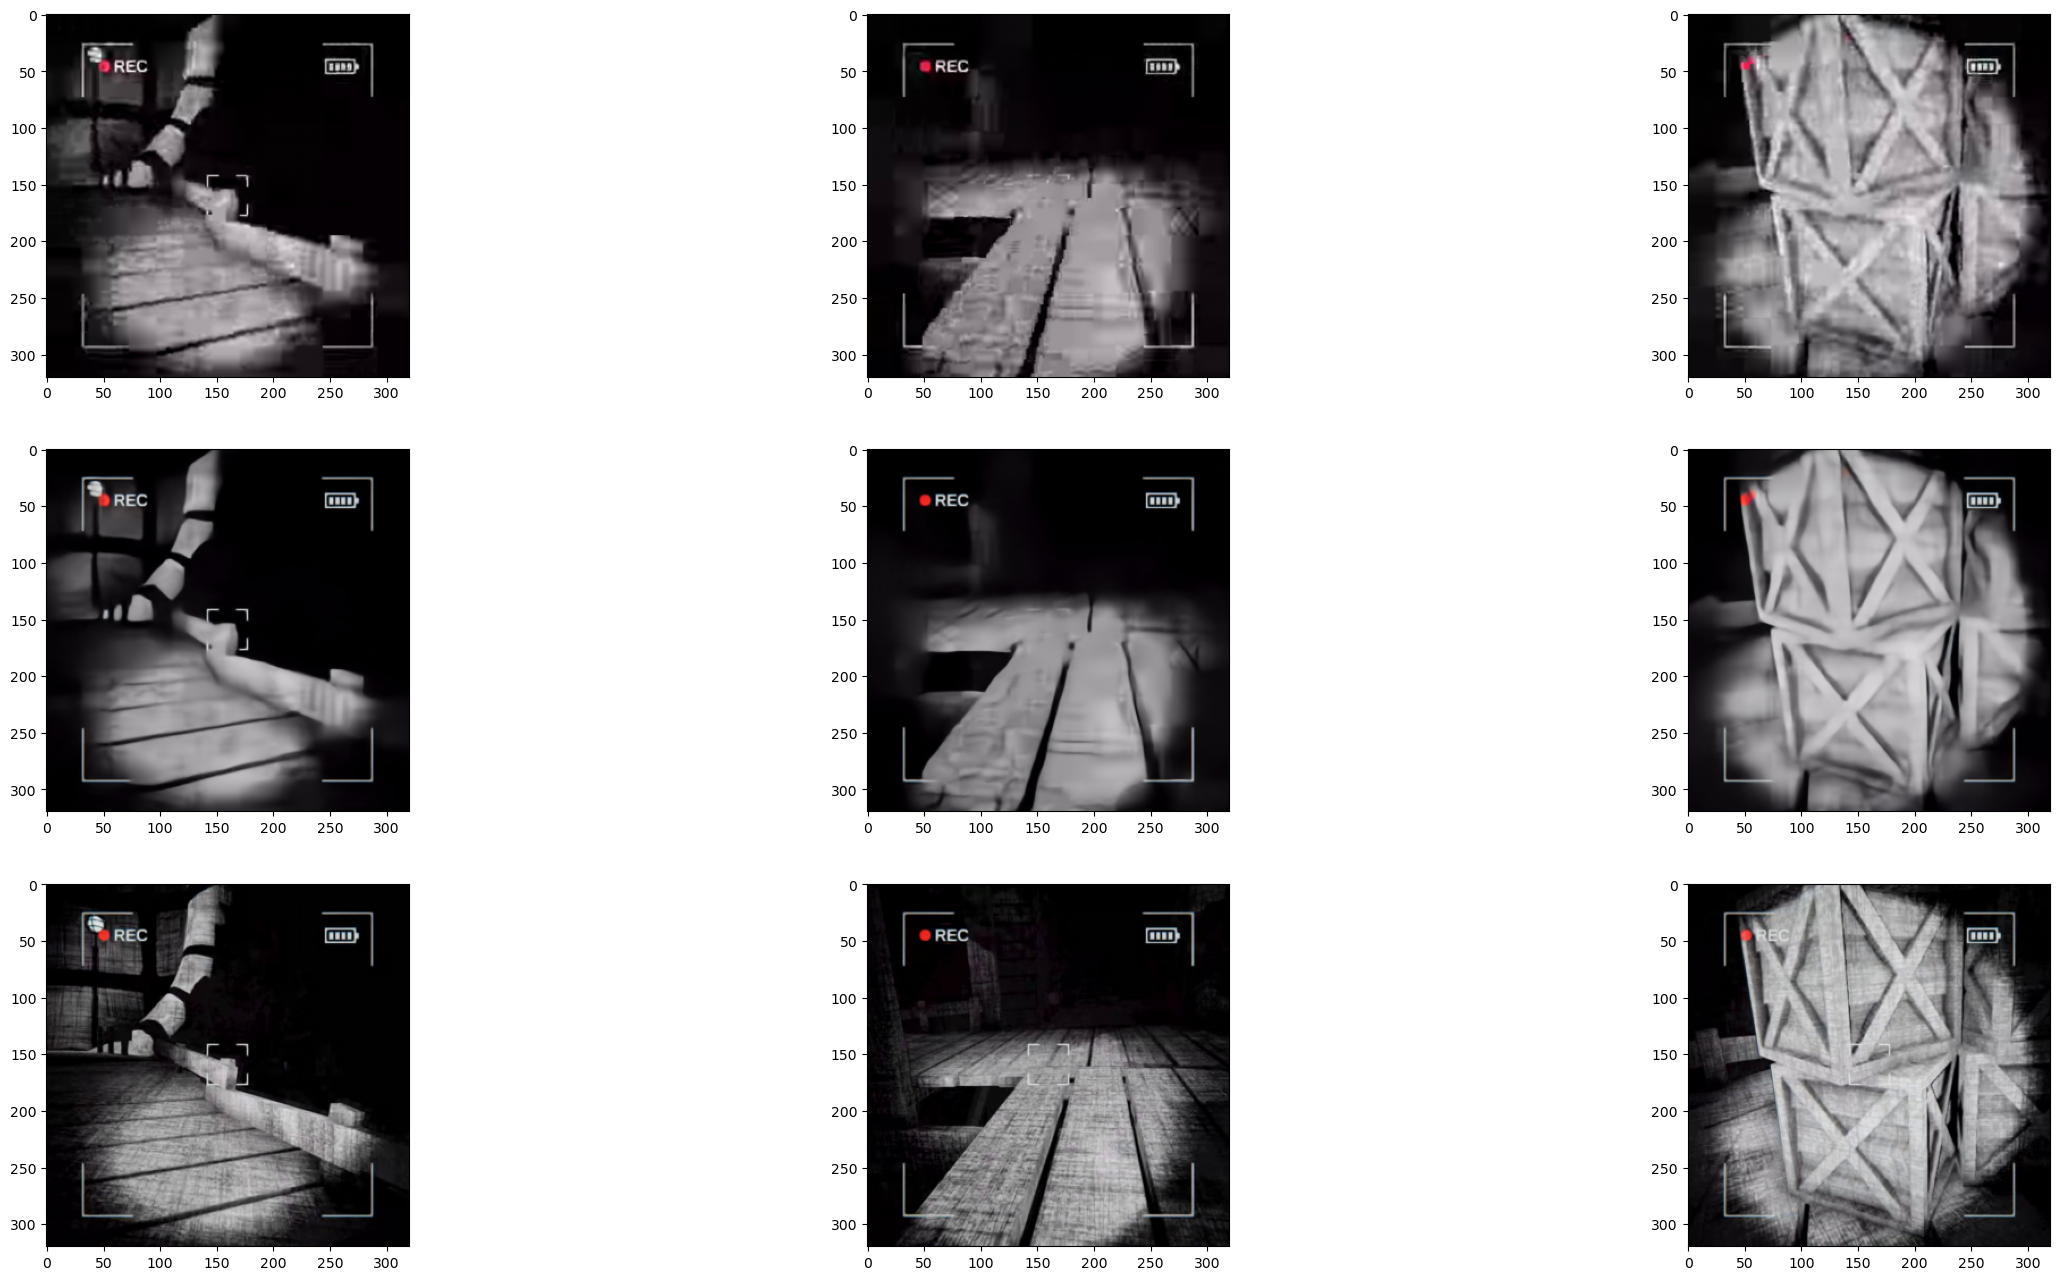

KeyboardInterrupt: 

In [13]:
start_time = time.time()
eval_time = time.time()
for i in range(1):
  print("epoch:", i + 1)
  model.train(True)
  for j, batch in enumerate(dataloader):
      x, y = batch
      
      optimiser.zero_grad()
      y_pred = model(x.to(device))
      loss = loss_fn(y_pred.float(), y.to(device))
      
      if time.time() - eval_time > save_interval:
        eval_time += save_interval
        torch.save(model.state_dict(), 'model.pth')
        x_c = x.to('cpu')
        y_c = y.to('cpu')
        y_pred_c = y_pred.to('cpu')
        print("Прошло времени: ", time.time() - start_time, 'c')
        show_images_real(x_c, y_pred_c, y_c, 3)  
          
      iterations += batch_size
      writer.add_scalar("Loss/image", loss, iterations)
      
      loss.backward()
      optimiser.step()
      
  evaluate(model, val_loader, loss_fn, device)
  print("Прошло времени: ", time.time() - start_time, 'c')
print("Время затраченное на обучение:", time.time() - start_time)